In [1]:
# Importing oversampler library
from imblearn.over_sampling import RandomOverSampler

In [2]:
# Importing the libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
#Impoting metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [4]:
# Importing libraries for cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [5]:
# Importing scikit logistic regression module
from sklearn.linear_model import LogisticRegression

In [6]:
%store -r X_train
%store -r y_train
%store -r X_test
%store -r y_test

In [7]:
# ROC Curve function

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [8]:
# instantiating the random oversampler 
ros = RandomOverSampler()
# resampling X, y
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

In [9]:
from collections import Counter
# Befor sampling class distribution
print('Before sampling class distribution:-',Counter(y_train))
# new class distribution 
print('New class distribution:-',Counter(y_train_ros))

Before sampling class distribution:- Counter({0: 227449, 1: 396})
New class distribution:- Counter({0: 227449, 1: 227449})


In [10]:
# Creating KFold object with 5 splits
folds = KFold(n_splits=5, shuffle=True, random_state=4)

# Specify params
params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}

# Specifing score as roc-auc
model_cv = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = params, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 

# Fit the model
model_cv.fit(X_train_ros, y_train_ros)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [11]:
# results of grid search CV
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.989769,0.566570,0.058162,0.018249,0.01,{'C': 0.01},0.988633,0.988563,0.988350,0.988340,...,0.988621,0.000321,6,0.988651,0.988583,0.988690,0.988764,0.988538,0.988645,0.000079
1,2.458536,0.121463,0.067268,0.013364,0.1,{'C': 0.1},0.988647,0.988573,0.988366,0.988337,...,0.988635,0.000331,5,0.988667,0.988596,0.988697,0.988778,0.988553,0.988658,0.000079
2,2.384024,0.047269,0.071079,0.007430,1,{'C': 1},0.988646,0.988576,0.988367,0.988334,...,0.988636,0.000333,4,0.988669,0.988596,0.988696,0.988776,0.988553,0.988658,0.000078
3,2.503642,0.140029,0.070729,0.008523,10,{'C': 10},0.988646,0.988576,0.988367,0.988335,...,0.988636,0.000332,1,0.988669,0.988596,0.988696,0.988776,0.988554,0.988658,0.000078
4,2.398812,0.129408,0.070895,0.008806,100,{'C': 100},0.988646,0.988576,0.988367,0.988335,...,0.988636,0.000332,2,0.988669,0.988596,0.988696,0.988776,0.988553,0.988658,0.000078
5,2.452781,0.139168,0.072540,0.004634,1000,{'C': 1000},0.988646,0.988576,0.988367,0.988335,...,0.988636,0.000332,3,0.988669,0.988596,0.988696,0.988776,0.988553,0.988658,0.000078


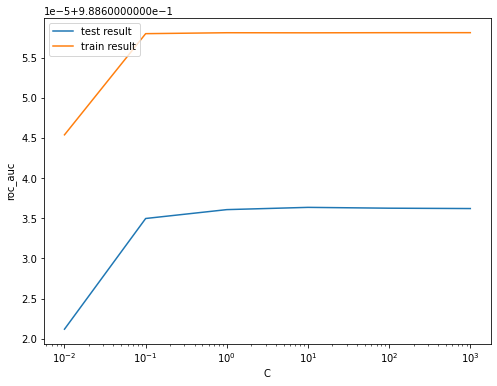

In [12]:
# plot of C versus train and validation scores

plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('roc_auc')
plt.legend(['test result', 'train result'], loc='upper left')
plt.xscale('log')

In [13]:
# Best score with best C
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']

print(" The highest test roc_auc is {0} at C = {1}".format(best_score, best_C))

 The highest test roc_auc is 0.988636368338455 at C = 10


In [14]:
# Instantiate the model with best C
logistic_bal_ros = LogisticRegression(C=0.1)

In [15]:
# Fit the model on the train set
logistic_bal_ros_model = logistic_bal_ros.fit(X_train_ros, y_train_ros)

In [16]:
# Predictions on the train set
y_train_pred = logistic_bal_ros_model.predict(X_train_ros)

In [17]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_train_ros, y_train_pred)
print(confusion)

[[222254   5195]
 [ 17736 209713]]


In [18]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [19]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train_ros, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

# F1 score
print("F1-Score:-", f1_score(y_train_ros, y_train_pred))

Accuracy:- 0.9495908973000541
Sensitivity:- 0.922022079675004
Specificity:- 0.9771597149251041
F1-Score:- 0.9481617788347421


In [20]:
# classification_report
print(classification_report(y_train_ros, y_train_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95    227449
           1       0.98      0.92      0.95    227449

    accuracy                           0.95    454898
   macro avg       0.95      0.95      0.95    454898
weighted avg       0.95      0.95      0.95    454898



In [21]:
# Predicted probability
y_train_pred_proba = logistic_bal_ros_model.predict_proba(X_train_ros)[:,1]

In [22]:
# roc_auc
auc = metrics.roc_auc_score(y_train_ros, y_train_pred_proba)
auc

0.9886539760033652

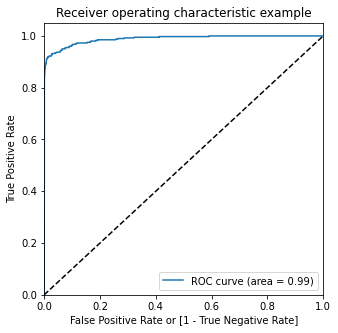

In [23]:
# Plot the ROC curve
draw_roc(y_train_ros, y_train_pred_proba)

In [24]:
# Prediction on the test set
y_test_pred = logistic_bal_ros_model.predict(X_test)

In [25]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_test, y_test_pred)
print(confusion)

[[55533  1333]
 [   11    85]]


In [26]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [27]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.9764053228468101
Sensitivity:- 0.8854166666666666
Specificity:- 0.97655892800619


In [28]:
# classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56866
           1       0.06      0.89      0.11        96

    accuracy                           0.98     56962
   macro avg       0.53      0.93      0.55     56962
weighted avg       1.00      0.98      0.99     56962



In [29]:
# Predicted probability
y_test_pred_proba = logistic_bal_ros_model.predict_proba(X_test)[:,1]

In [30]:
# roc_auc
auc = metrics.roc_auc_score(y_test, y_test_pred_proba)
auc

0.9711194225606397

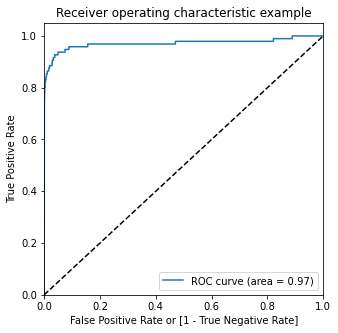

In [31]:
# Plot the ROC curve
draw_roc(y_test, y_test_pred_proba)

In [32]:
# Importing XGBoost
from xgboost import XGBClassifier

In [33]:
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          


# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train_ros, y_train_ros)  

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...one,
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                 

In [34]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,38.204106,0.099795,0.284492,0.008995,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.999908,0.999913,0.999922,0.999914,0.000006,5,0.999923,0.999919,0.999938,0.999927,7.929471e-06
1,48.820828,0.074445,0.273110,0.002741,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.999925,0.999926,0.999903,0.999918,0.000011,4,0.999936,0.999924,0.999924,0.999928,5.887975e-06
2,52.984850,0.387326,0.273212,0.007405,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.999904,0.999929,0.999903,0.999912,0.000012,6,0.999924,0.999930,0.999924,0.999926,2.717449e-06
3,38.106231,0.196294,0.287731,0.012036,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.999992,0.999982,0.999980,0.999984,0.000005,3,0.999999,0.999995,1.000000,0.999998,2.069106e-06
4,49.104698,2.600441,0.269753,0.016016,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.999998,0.999988,0.999974,0.999986,0.000010,2,1.000000,0.999996,0.999998,0.999998,1.773923e-06
5,38.465756,3.389952,0.179600,0.007338,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.999997,0.999996,0.999982,0.999992,0.000007,1,0.999999,1.000000,0.999999,0.999999,2.129049e-07


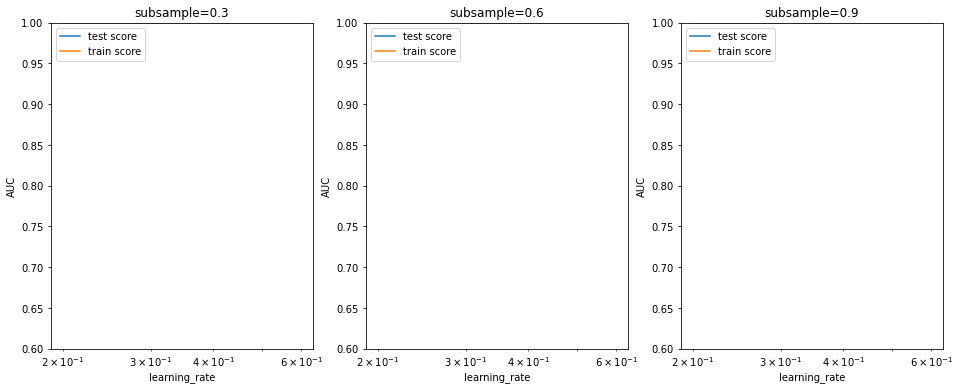

In [35]:
# # plotting
plt.figure(figsize=(16,6))

param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]} 


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

In [36]:
model_cv.best_params_

{'learning_rate': 0.6, 'subsample': 0.9}

In [37]:
# chosen hyperparameters
params = {'learning_rate': 0.6,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.9,
         'objective':'binary:logistic'}

# fit model on training data
xgb_bal_ros_model = XGBClassifier(params = params)
xgb_bal_ros_model.fit(X_train_ros, y_train_ros)

[18:06:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1,
              params={'learning_rate': 0.6, 'max_depth': 2, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'subsample': 0.9},
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [38]:
# Predictions on the train set
y_train_pred = xgb_bal_ros_model.predict(X_train_ros)

In [39]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_train_ros, y_train_ros)
print(confusion)

[[227449      0]
 [     0 227449]]


In [40]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [41]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train_ros, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 1.0
Sensitivity:- 1.0
Specificity:- 1.0


In [42]:
# classification_report
print(classification_report(y_train_ros, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227449
           1       1.00      1.00      1.00    227449

    accuracy                           1.00    454898
   macro avg       1.00      1.00      1.00    454898
weighted avg       1.00      1.00      1.00    454898



In [43]:
# Predicted probability
y_train_pred_proba = xgb_bal_ros_model.predict_proba(X_train_ros)[:,1]

In [44]:
# roc_auc
auc = metrics.roc_auc_score(y_train_ros, y_train_pred_proba)
auc

1.0

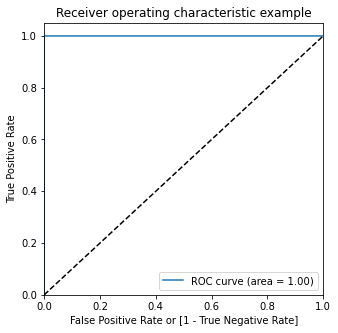

In [45]:
# Plot the ROC curve
draw_roc(y_train_ros, y_train_pred_proba)

In [46]:
# Predictions on the test set
y_test_pred = xgb_bal_ros_model.predict(X_test)

In [47]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_test, y_test_pred)
print(confusion)

[[56854    12]
 [   20    76]]


In [48]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [49]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.9994382219725431
Sensitivity:- 0.7916666666666666
Specificity:- 0.9997889775964548


In [50]:
# classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56866
           1       0.86      0.79      0.83        96

    accuracy                           1.00     56962
   macro avg       0.93      0.90      0.91     56962
weighted avg       1.00      1.00      1.00     56962



In [51]:
# Predicted probability
y_test_pred_proba = xgb_bal_ros_model.predict_proba(X_test)[:,1]

In [52]:
# roc_auc
auc = metrics.roc_auc_score(y_test, y_test_pred_proba)
auc

0.9766746972414682

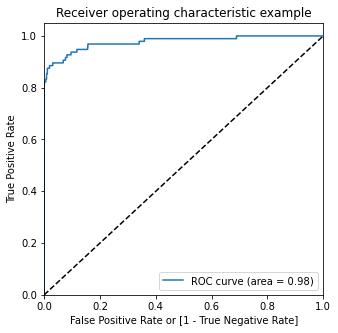

In [53]:

# Plot the ROC curve
draw_roc(y_test, y_test_pred_proba)

In [54]:
# Importing decision tree classifier
from sklearn.tree import DecisionTreeClassifier

In [55]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}


# Instantiate the grid search model
dtree = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator = dtree, 
                           param_grid = param_grid, 
                           scoring= 'roc_auc',
                           cv = 3, 
                           verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train_ros,y_train_ros)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50)},
             scoring='roc_auc', verbose=1)

In [56]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,4.236459,0.247793,0.060872,0.010351,5,50,50,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.983894,0.983816,0.990278,0.985996,0.003028,6
1,4.275266,0.148297,0.061057,0.004011,5,50,100,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.983894,0.983818,0.990293,0.986002,0.003034,5
2,4.196899,0.114990,0.062883,0.009508,5,100,50,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.983885,0.983789,0.990202,0.985959,0.003001,7
3,4.256900,0.180620,0.061793,0.010481,5,100,100,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.983885,0.983779,0.990191,0.985952,0.002998,8
4,6.747213,0.312203,0.052729,0.008399,10,50,50,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.999606,0.999617,0.999589,0.999604,0.000011,1
5,6.652334,0.158438,0.061951,0.006011,10,50,100,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.999583,0.999616,0.999597,0.999599,0.000014,2
6,6.533980,0.286099,0.050733,0.006877,10,100,50,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.999573,0.999579,0.999588,0.999580,0.000006,3
7,8.124969,0.367688,0.085756,0.004793,10,100,100,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.999545,0.999582,0.999608,0.999578,0.000026,4


In [57]:
# Printing the optimal sensitivity score and hyperparameters
print("Best roc_auc:-", grid_search.best_score_)
print(grid_search.best_estimator_)

Best roc_auc:- 0.9996039287111494
DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50)


In [58]:
# Model with optimal hyperparameters
dt_bal_ros_model = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=100,
                                  min_samples_split=50)

dt_bal_ros_model.fit(X_train_ros, y_train_ros)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=100, min_samples_split=50,
                       random_state=100)

In [59]:
# Predictions on the train set
y_train_pred = dt_bal_ros_model.predict(X_train_ros)

In [60]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_train_ros, y_train_pred)
print(confusion)

[[225914   1535]
 [     0 227449]]


In [61]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [62]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train_ros, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.9966256171713219
Sensitivity:- 1.0
Specificity:- 0.9932512343426438


In [63]:
# classification_report
print(classification_report(y_train_ros, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    227449
           1       0.99      1.00      1.00    227449

    accuracy                           1.00    454898
   macro avg       1.00      1.00      1.00    454898
weighted avg       1.00      1.00      1.00    454898



In [64]:
# Predicted probability
y_train_pred_proba = dt_bal_ros_model.predict_proba(X_train_ros)[:,1]

In [65]:
# roc_auc
auc = metrics.roc_auc_score(y_train_ros, y_train_pred_proba)
auc

0.999764094856848

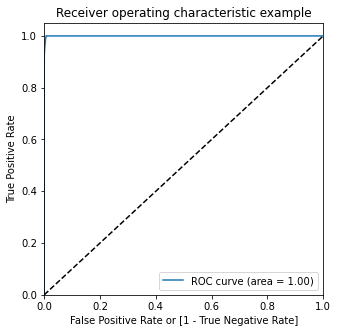

In [66]:
# Plot the ROC curve
draw_roc(y_train_ros, y_train_pred_proba)

In [67]:
# Predictions on the test set
y_test_pred = dt_bal_ros_model.predict(X_test)

In [68]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_test, y_test_pred)
print(confusion)

[[56431   435]
 [   20    76]]


In [69]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [70]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.9920122186720972
Sensitivity:- 0.7916666666666666
Specificity:- 0.9923504378714874


In [71]:
# classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56866
           1       0.15      0.79      0.25        96

    accuracy                           0.99     56962
   macro avg       0.57      0.89      0.62     56962
weighted avg       1.00      0.99      0.99     56962



In [72]:
# Predicted probability
y_test_pred_proba = dt_bal_ros_model.predict_proba(X_test)[:,1]

In [73]:
# roc_auc
auc = metrics.roc_auc_score(y_test, y_test_pred_proba)
auc

0.8948739324317987

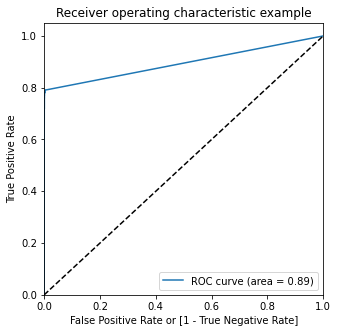

In [74]:
# Plot the ROC curve
draw_roc(y_test, y_test_pred_proba)

In [75]:
from sklearn.ensemble import RandomForestClassifier

In [76]:
rfc_imb_model = RandomForestClassifier(bootstrap=True,
                             max_depth=5,
                             min_samples_leaf=50, 
                             min_samples_split=50,
                             max_features=10,
                             n_estimators=100)

In [77]:
# Fit the model
rfc_imb_model.fit(X_train_ros, y_train_ros)

RandomForestClassifier(max_depth=5, max_features=10, min_samples_leaf=50,
                       min_samples_split=50)

In [78]:
# Predictions on the train set
y_train_pred = rfc_imb_model.predict(X_train_ros)

In [79]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_train_ros, y_train_pred)
print(confusion)

[[226848    601]
 [ 14835 212614]]


In [80]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [81]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train_ros, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.9660671183430132
Sensitivity:- 0.9347765872789064
Specificity:- 0.9973576494071198


In [82]:
# classification_report
print(classification_report(y_train_ros, y_train_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    227449
           1       1.00      0.93      0.96    227449

    accuracy                           0.97    454898
   macro avg       0.97      0.97      0.97    454898
weighted avg       0.97      0.97      0.97    454898



In [83]:
# Predicted probability
y_train_pred_proba = dt_bal_ros_model.predict_proba(X_train_ros)[:,1]

In [84]:
# roc_auc
auc = metrics.roc_auc_score(y_train_ros, y_train_pred_proba)
auc

0.999764094856848

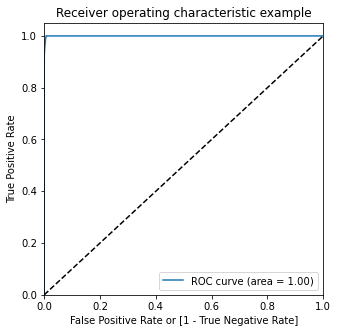

In [85]:
# Plot the ROC curve
draw_roc(y_train_ros, y_train_pred_proba)

In [86]:
# Predictions on the test set
y_test_pred = dt_bal_ros_model.predict(X_test)

In [87]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_test, y_test_pred)
print(confusion)

[[56431   435]
 [   20    76]]


In [88]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [89]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.9920122186720972
Sensitivity:- 0.7916666666666666
Specificity:- 0.9923504378714874


In [90]:
# classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56866
           1       0.15      0.79      0.25        96

    accuracy                           0.99     56962
   macro avg       0.57      0.89      0.62     56962
weighted avg       1.00      0.99      0.99     56962



In [91]:
# Predicted probability
y_test_pred_proba = dt_bal_ros_model.predict_proba(X_test)[:,1]

In [92]:
# roc_auc
auc = metrics.roc_auc_score(y_test, y_test_pred_proba)
auc

0.8948739324317987

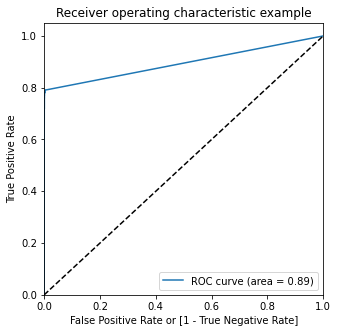

In [93]:
# Plot the ROC curve
draw_roc(y_test, y_test_pred_proba)

In [94]:
%store logistic_bal_ros_model
%store xgb_bal_ros_model
%store dt_bal_ros_model
%store rfc_imb_model

Stored 'logistic_bal_ros_model' (LogisticRegression)
Stored 'xgb_bal_ros_model' (XGBClassifier)
Stored 'dt_bal_ros_model' (DecisionTreeClassifier)
Stored 'rfc_imb_model' (RandomForestClassifier)
